### Visualizing the distribution of the observations

### Load the required libraries

In [3]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
# sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

# from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSBSBS'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12583
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|    43|[D0 5B 00 5C 00 7...|1950.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|    42|[78 5B D0 5B 00 7...|1951.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|     5|[6C 5C 58 5C 2C 5...|1952.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|     0|[14 5C 20 5B 14 5...|1953.0|BSBSBSBS|
|      2.1| 25.3867| -80.5936|       TMAX|USC00087760|     0|[D0 5B 14 5C 6C 5...|1954.0|BSBSBSBS|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [7]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('SNOW')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1 = df1.sort(df1.year)
df1.show(2)
df1 = df1.sort(df1.year,ascending=False)
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
12583 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      3.0|   26.55|   -80.05|       PRCP|USC00084198|    31|[00 00 00 00 00 0...|1892.0|BSBSBSBS|
|      4.3| 26.3675| -80.1108|       TMIN|USC00080845|    42|[E0 54 40 4C 00 4...|1898.0|BSBSBSBS|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows

+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|      2.1| 25.3867| -80.5936|       TMIN|USC000877

(12583L, 365L)

### Script for plotting yearly plots

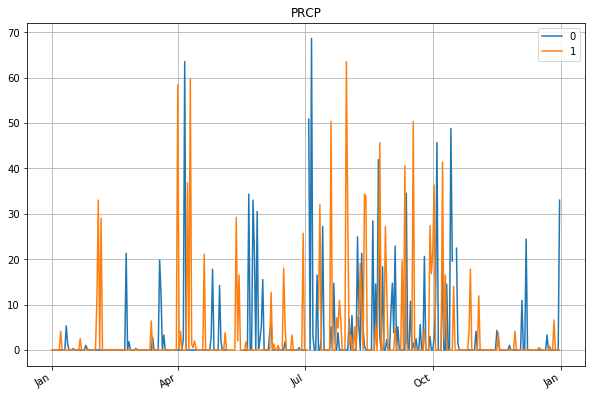

In [10]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [7]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

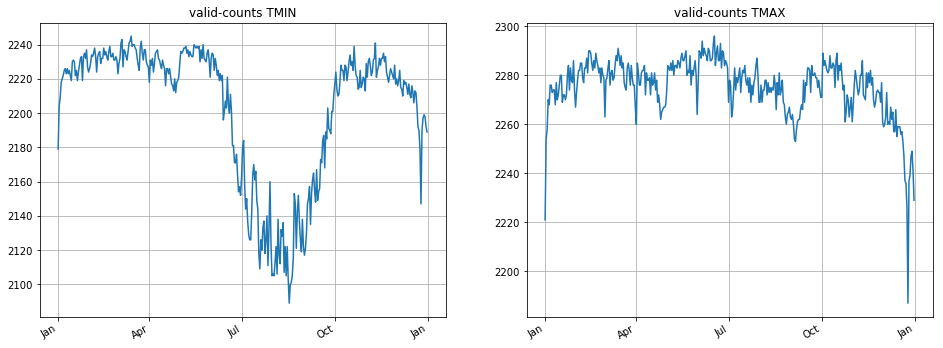

In [28]:
plot_pair(['TMIN','TMAX'],plot_valid)

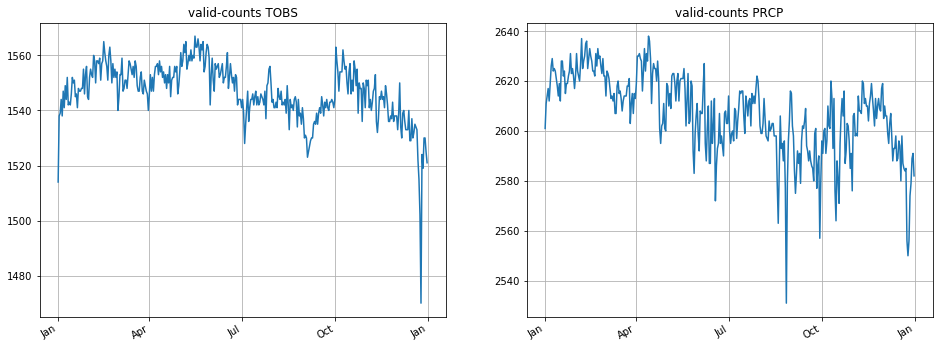

In [29]:
plot_pair(['TOBS','PRCP'],plot_valid)

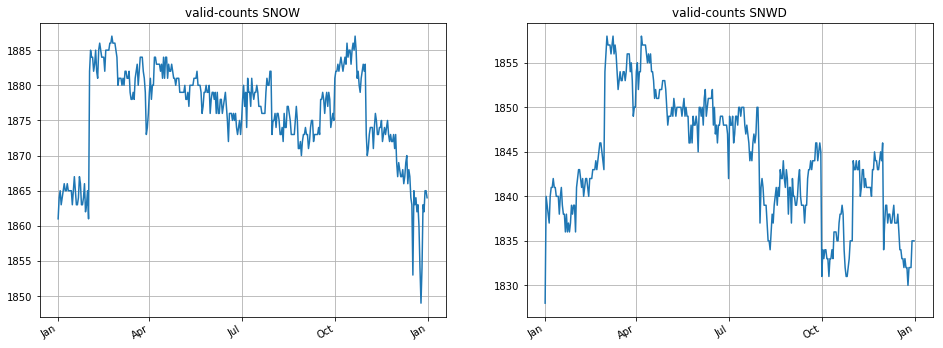

In [30]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [8]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m)

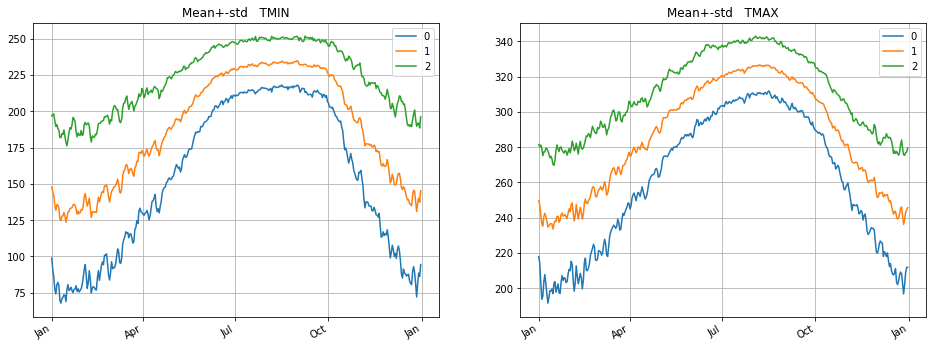

In [12]:
plot_pair(['TMIN','TMAX'],plot_mean_std)

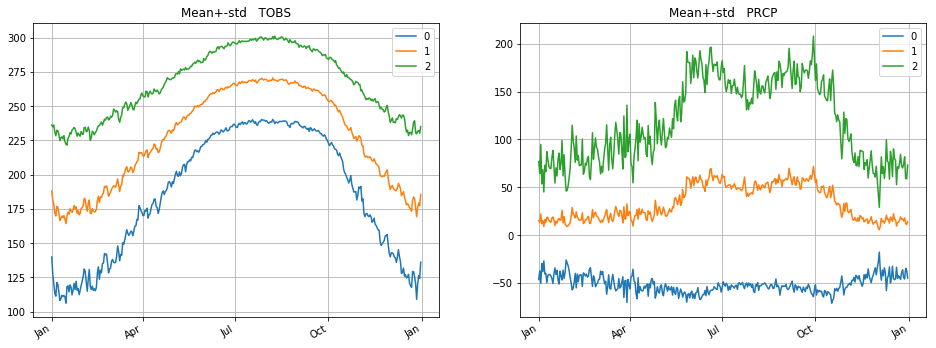

In [13]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

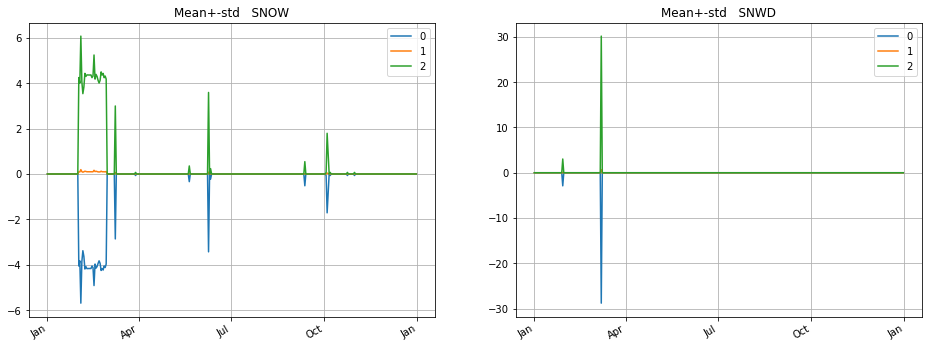

In [34]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [35]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

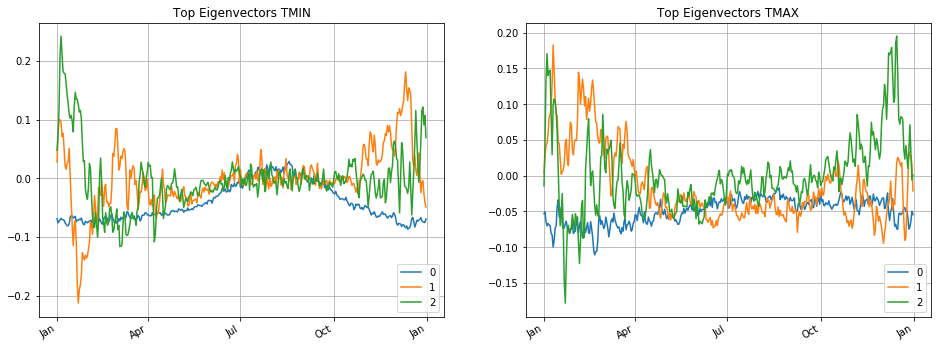

In [36]:
plot_pair(['TMIN','TMAX'],plot_eigen)

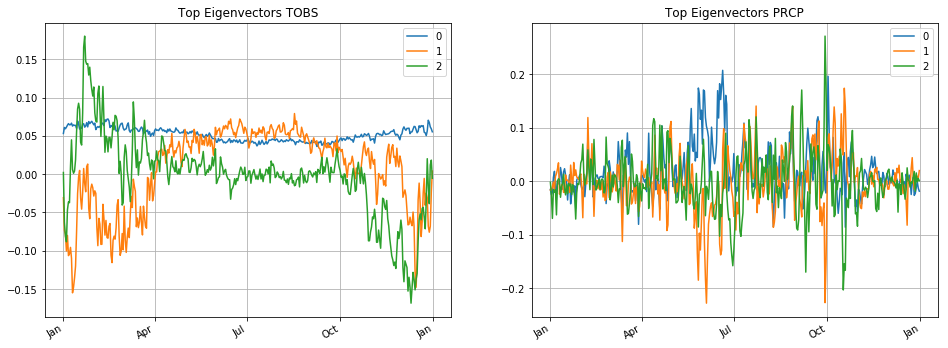

In [37]:
plot_pair(['TOBS','PRCP'],plot_eigen)

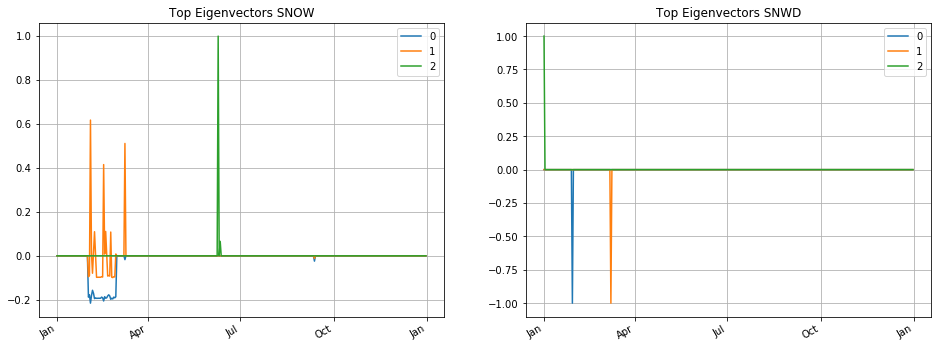

In [38]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [39]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

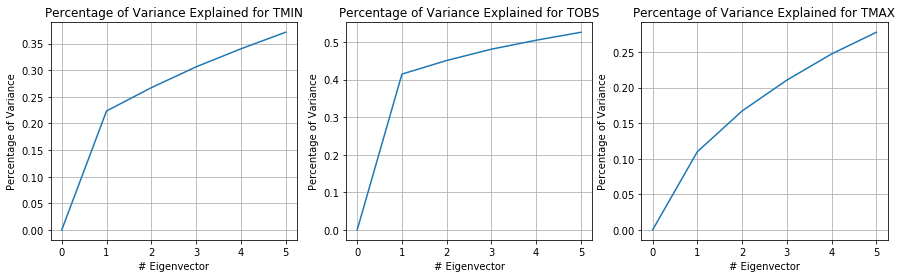

In [40]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

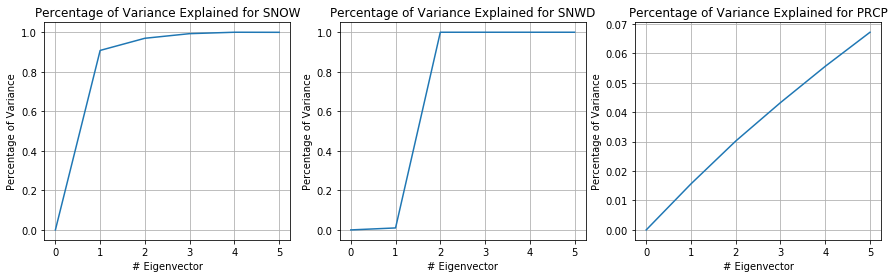

In [41]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [42]:
#sc.stop()